--- Simulating 1D Photonic Crystal ---

Kernel               | MSE        | R2        
---------------------------------------------
rbf                  | 0.0538     | 0.5648
linear               | 0.1302     | -0.0534
poly                 | 0.1262     | -0.0213
sigmoid              | 2678435.8198     | -21670560.5363
custom_jackson       | 0.0370     | 0.7010


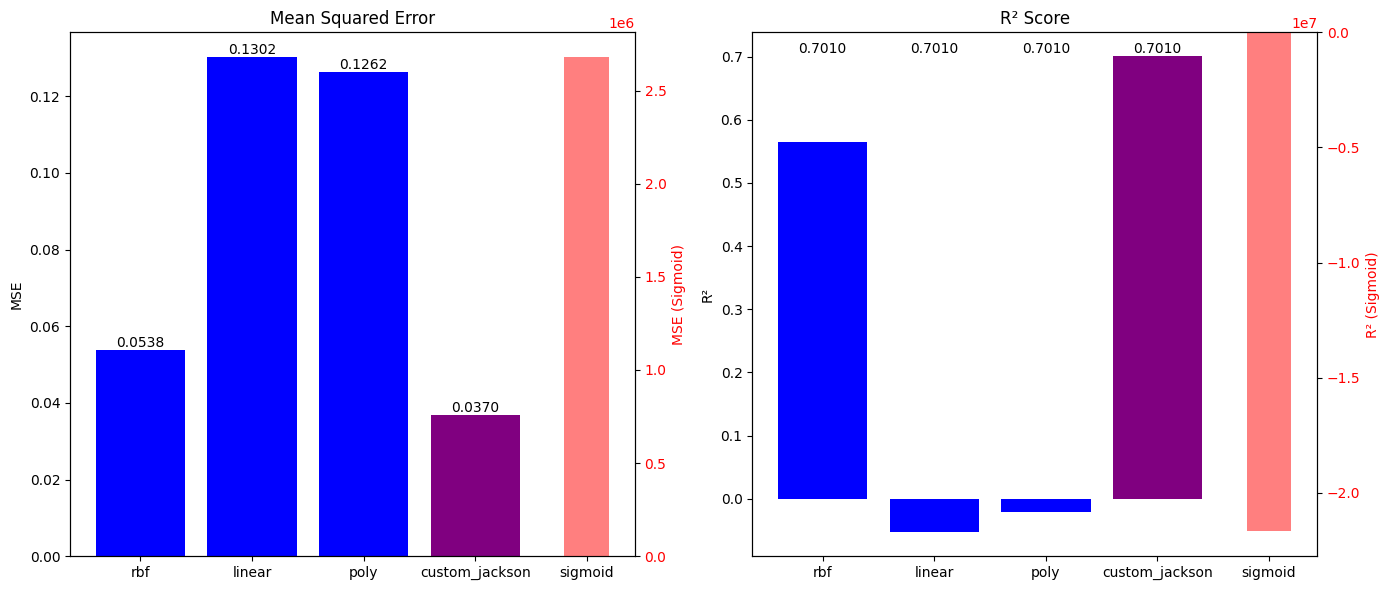

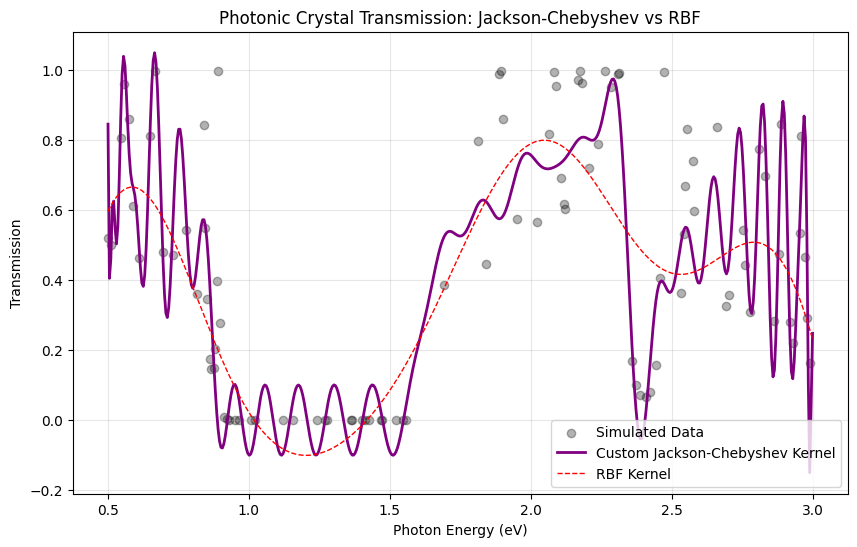

In [14]:
# -----------------------------------------------------------------------------
# Copyright (c) 2025 Renata Wong
#
# This code is supplementary material for the research paper:
# "Support Vector Machine Kernels as Quantum Propagators"
#
# Licensed under the MIT License.
# You may obtain a copy of the License at: https://opensource.org/licenses/MIT
# -----------------------------------------------------------------------------


import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.linalg import eigh

# -----------------------------------------------------------------------------
# 1. PHYSICAL SIMULATION (Si/SiO2 Photonic Crystal)
# -----------------------------------------------------------------------------
print("--- Simulating 1D Photonic Crystal ---")

energies = np.linspace(0.5, 3.0, 500) 

def n_Si(E):
    # Sellmeier-like approximation for Silicon
    lam_microns = 1.2398 / (E + 1e-6)
    epsilon = 11.6858 + 0.939816 / (lam_microns**2) + 8.10461e-3 * lam_microns**2
    return np.sqrt(epsilon)

def n_SiO2(E):
    # Silica (nearly constant)
    return 1.45 * np.ones_like(E)

def solve_tmm(energies, layers):
    T_list = []
    for E in energies:
        lam = 1.2398 / E
        k0 = 2 * np.pi / lam
        M = np.eye(2, dtype=complex)
        for (n_func, d) in layers:
            n = n_func(E)
            phi = n * k0 * d
            M_layer = np.array([
                [np.cos(phi), -1j/n * np.sin(phi)],
                [-1j*n * np.sin(phi), np.cos(phi)]
            ])
            M = np.dot(M, M_layer)
        m11, m12, m21, m22 = M[0,0], M[0,1], M[1,0], M[1,1]
        t = 2 / (m11 + m12 + m21 + m22)
        T_list.append(np.abs(t)**2)
    return np.array(T_list)

center_E = 1.24
d_Si = (1.2398 / center_E) / (4 * n_Si(center_E))
d_SiO2 = (1.2398 / center_E) / (4 * n_SiO2(center_E))
layers = []
for _ in range(10): # 10 periods
    layers.append((n_Si, d_Si))
    layers.append((n_SiO2, d_SiO2))

transmission = solve_tmm(energies, layers)

# -----------------------------------------------------------------------------
# 2. ALGORITHM 1: CUSTOM KERNEL
# -----------------------------------------------------------------------------
class JacksonChebyshevKernel:
    def __init__(self, degree=60, clip_eigen=True):
        self.degree = degree
        self.clip_eigen = clip_eigen
        self.x_min = None
        self.x_max = None
        
    def _scale(self, X):
        # Map to [-0.99, 0.99] to stay within domain of arccos
        # Input X can be (N, 1) or (N,). We preserve shape here.
        X_std = (X - self.x_min) / (self.x_max - self.x_min)
        return X_std * 1.98 - 0.99

    def fit(self, X):
        self.x_min = np.min(X)
        self.x_max = np.max(X)
        return self

    def compute_gram_matrix(self, X1, X2):
        # FIX: Flatten inputs to 1D to ensure proper broadcasting
        # X1 is likely (N1, 1), we want (N1,)
        x1_s = self._scale(X1).flatten()
        x2_s = self._scale(X2).flatten()
        
        N = self.degree
        
        # 1. Compute Jackson Coefficients g_n (Shape: (N,))
        n = np.arange(N)
        # Avoid division by zero issues in cot(pi/(N+1)) by handling implicitly
        theta = np.pi / (N + 1)
        sin_n = np.sin(n * theta)
        cos_n = np.cos(n * theta)
        cot_theta = 1.0 / np.tan(theta)
        
        g_n = ((N - n + 1) * cos_n + sin_n * cot_theta) / (N + 1)
        
        # 2. Compute Chebyshev Features T_n(x) (Shape: (Samples, Degree))
        # np.arccos(x1_s) is (Samples,). [:, None] makes it (Samples, 1).
        # n is (Degree,).
        # Broadcasting: (Samples, 1) * (Degree,) -> (Samples, Degree)
        feats1 = np.cos(np.arccos(x1_s)[:, None] * n)
        feats2 = np.cos(np.arccos(x2_s)[:, None] * n)
        
        # 3. Weighted Dot Product
        # We apply sqrt(g_n) to both sides so that K = F1 @ F2.T
        # Broadcasting: (Samples, Degree) * (Degree,)
        weighted_feats1 = feats1 * np.sqrt(g_n)
        weighted_feats2 = feats2 * np.sqrt(g_n)
        
        return weighted_feats1 @ weighted_feats2.T

    def get_train_kernel(self, X_train):
        self.fit(X_train)
        K = self.compute_gram_matrix(X_train, X_train)
        
        if self.clip_eigen:
            # Spectral Clipping
            vals, vecs = eigh(K)
            vals[vals < 0] = 0
            K = vecs @ np.diag(vals) @ vecs.T
            
        return K
    
    def get_test_kernel(self, X_train, X_test):
        return self.compute_gram_matrix(X_test, X_train)

# -----------------------------------------------------------------------------
# 3. PREPARE DATA
# -----------------------------------------------------------------------------
X = energies.reshape(-1, 1)
y = transmission

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaler (Used only for standard kernels)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Custom Kernel setup (Uses raw X, internally scaled)
jackson = JacksonChebyshevKernel(degree=60, clip_eigen=True)
K_train_cust = jackson.get_train_kernel(X_train)
K_test_cust = jackson.get_test_kernel(X_train, X_test)

# -----------------------------------------------------------------------------
# 4. TRAIN & EVALUATE
# -----------------------------------------------------------------------------
kernels = ['rbf', 'linear', 'poly', 'sigmoid', 'custom_jackson']
results = {}

print(f"\n{'Kernel':<20} | {'MSE':<10} | {'R2':<10}")
print("-" * 45)

for k in kernels:
    if k == 'custom_jackson':
        # Use PRECOMPUTED kernel
        model = SVR(kernel='precomputed', C=100)
        model.fit(K_train_cust, y_train)
        y_pred = model.predict(K_test_cust)
        
    else:
        # Use STANDARD kernels
        model = SVR(kernel=k, C=100, gamma='scale')
        if k == 'poly': model.degree = 3
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[k] = {'MSE': mse, 'R2': r2}
    print(f"{k:<20} | {mse:.4f}     | {r2:.4f}")

# -----------------------------------------------------------------------------
# 5. PLOT BAR GRAPHS
# -----------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

names = [k for k in kernels if k != 'sigmoid']
mse_vals = [results[k]['MSE'] for k in names]
r2_vals = [results[k]['R2'] for k in names]
colors = ['blue' if 'custom' not in k else 'purple' for k in names]

# MSE
bars1 = ax1.bar(names, mse_vals, color=colors)
ax1.set_title("Mean Squared Error")
ax1.set_ylabel("MSE")
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.4f}", ha='center', va='bottom')

# Sigmoid MSE (Twin)
if 'sigmoid' in results:
    ax1t = ax1.twinx()
    ax1t.bar(['sigmoid'], [results['sigmoid']['MSE']], color='red', width=0.4, alpha=0.5)
    ax1t.set_ylabel("MSE (Sigmoid)", color='red')
    ax1t.tick_params(axis='y', labelcolor='red')

# R2
bars2 = ax2.bar(names, r2_vals, color=colors)
ax2.set_title("R² Score")
ax2.set_ylabel("R²")
for bar in bars2:
    #val = bar.get_height()
    #va = 'bottom' if val >= 0 else 'top'
    y_pos = val if val >= 0 else val - 0.05
    ax2.text(bar.get_x() + bar.get_width()/2, y_pos, f"{val:.4f}", ha='center', va='bottom')

# Sigmoid R2 (Twin)
if 'sigmoid' in results:
    ax2t = ax2.twinx()
    ax2t.bar(['sigmoid'], [results['sigmoid']['R2']], color='red', width=0.4, alpha=0.5)
    ax2t.set_ylabel("R² (Sigmoid)", color='red')
    ax2t.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.savefig("jackson_metrics.png")
plt.show()

# -----------------------------------------------------------------------------
# 6. PLOT SPECTRUM CURVE (RBF vs Jackson-Chebyshev)
# -----------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='black', alpha=0.3, label='Simulated Data')

# Compute Prediction Curve for Jackson
X_grid = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
K_grid_jackson = jackson.get_test_kernel(X_train, X_grid)

# Re-fit to ensure scope
model_jackson = SVR(kernel='precomputed', C=100)
model_jackson.fit(K_train_cust, y_train)
y_grid_jackson = model_jackson.predict(K_grid_jackson)

plt.plot(X_grid, y_grid_jackson, color='purple', linewidth=2, label='Custom Jackson-Chebyshev Kernel')

# Compute Prediction Curve for RBF
model_rbf = SVR(kernel='rbf', C=100, gamma='scale')
model_rbf.fit(X_train_scaled, y_train)
y_grid_rbf = model_rbf.predict(scaler_X.transform(X_grid))
plt.plot(X_grid, y_grid_rbf, color='red', linestyle='--', linewidth=1, label='RBF Kernel')

plt.title("Photonic Crystal Transmission: Jackson-Chebyshev vs RBF")
plt.xlabel("Photon Energy (eV)")
plt.ylabel("Transmission")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("jackson_spectrum.png")
plt.show()